In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.functional import rotate
from torchvision.transforms import ToTensor, Lambda,Compose
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle

%matplotlib inline

### Define transformation to rotatate images by a given angle

In [2]:
class ROTATE(object):
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img):
        return rotate(img,angle=self.angle)

### Data set:

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


In [4]:
train_dataloaderF = DataLoader(training_data, batch_size=256,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Model: A simple FFNN

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Loss

In [7]:
loss_fn = nn.CrossEntropyLoss()

### Implementation of AUXMOM: 

In [8]:
def compute_grad(model,X,y,device=device):
    g = [None for _ in model.parameters()]
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for i,param in enumerate(model.parameters()):
            g[i] = param.grad
    return g, loss

In [9]:
def AUXMOM(K,lrs,a, model, loss_fn,epochs):

    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    for t in range(epochs):
              #print(f"Epoch {t+1}\n-------------------------------")
            size = len(train_dataloaderF.dataset)
            m_f = [None for _ in model.parameters()]
            dloadH = iter(train_dataloaderH)
            for batch, (X, y) in enumerate(train_dataloaderF):
                lr = lrs[t*len(train_dataloaderF) + batch]
                backup = copy.deepcopy(model).to(device)
                
                g_f,_ = compute_grad(model,X,y,device=device)
                with torch.no_grad():
                    for i in range(len(m_f)):
                        m_f[i] = g_f[i] if (batch==0 and t==0) else (1-a)*m_f[i] + a*g_f[i]

                
                for k in range(K):
                    try:
                        (X, y) = next(dloadH)
                    except StopIteration:
                        dloadH = iter(train_dataloaderH)
                        (X, y) = next(dloadH)
                        X, y = X.to(device), y.to(device)
                   # Compute prediction and loss
                    grad_hx,_ = compute_grad(backup,X,y,device=device)
                    grad_hy, loss = compute_grad(model,X,y,device=device)
                    
                    with torch.no_grad():
                        for i,param in enumerate(model.parameters()):
                            param -= lr * (grad_hy[i] - grad_hx[i] + m_f[i])
                                   
                if batch % 50 == 0:
                    loss, current = loss.item(), batch * len(X)
                        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    Res["train_loss"].append(loss)
                        #test
                    size = len(test_dataloader.dataset)
                    num_batches = len(test_dataloader)
                    test_loss, correct = 0, 0

                    with torch.no_grad():
                        for X, y in test_dataloader:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            test_loss += loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                    test_loss /= num_batches
                    correct /= size
                    Res["test_loss"].append(test_loss)
                    Res["test_acc"].append(correct)
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [10]:
def AUXMOM(K,lrs,a, model, loss_fn,epochs):

    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    for t in tqdm(range(epochs)):
              #print(f"Epoch {t+1}\n-------------------------------")
            size = len(train_dataloaderF.dataset)
            m = [None for _ in model.parameters()]
            dloadH = iter(train_dataloaderH)
            for batch, (X, y) in enumerate(train_dataloaderF):
                lr = lrs[t*len(train_dataloaderF) + batch]
                
                g_f,_ = compute_grad(model,X,y,device=device)
                
                try:
                        (X, y) = next(dloadH)
                except StopIteration:
                        dloadH = iter(train_dataloaderH)
                        (X, y) = next(dloadH)
                        X, y = X.to(device), y.to(device)
                g_h,_ = compute_grad(model,X,y,device=device)
                
                with torch.no_grad():
                    for i in range(len(m)):
                        m[i] = g_f[i] - g_h[i] if (batch==0 and t==0) else (1-a)*m[i] + a*(g_f[i] - g_h[i])
                for k in range(K):
                    try:
                        (X, y) = next(dloadH)
                    except StopIteration:
                        dloadH = iter(train_dataloaderH)
                        (X, y) = next(dloadH)
                        X, y = X.to(device), y.to(device)
                   # Compute prediction and loss
                    grad_hy, loss = compute_grad(model,X,y,device=device)
                    
                    with torch.no_grad():
                        for i,param in enumerate(model.parameters()):
                            param -= lr * (grad_hy[i] + m[i])
                                   
                if batch % 50 == 0:
                    loss, current = loss.item(), batch * len(X)
                        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    Res["train_loss"].append(loss)
                        #test
                    size = len(test_dataloader.dataset)
                    num_batches = len(test_dataloader)
                    test_loss, correct = 0, 0

                    with torch.no_grad():
                        for X, y in test_dataloader:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            test_loss += loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                    test_loss /= num_batches
                    correct /= size
                    Res["test_loss"].append(test_loss)
                    Res["test_acc"].append(correct)
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [23]:
Ks = [1,5,10] 
Angles = [0,45,90,180]
trials = 1
epochs = 10
T = np.arange(len(train_dataloaderF)*epochs) + 1
lrs = 1e-2 * np.ones_like(T) #1e-1 / np.sqrt(T)
a = 0.1
for angle in Angles:
    print("Angle=", angle)
    Res = {K:{} for K in Ks}
    training_data_rotated = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(),ROTATE(angle)])
    )
    train_dataloaderH = DataLoader(training_data_rotated, batch_size=64,shuffle=True)
    for K in Ks:
        print("K=",K)
        for t in range(trials):
            print("---------t=",t)
            model = NeuralNetwork().to(device)
            Res[K][t] = AUXMOM(K,lrs,a, model, loss_fn,epochs)
    with open(f'results/MnistExp_angle{angle}.pkl', 'wb') as f:
        pickle.dump(Res, f)

Angle= 0
K= 1
---------t= 0
K= 5
---------t= 0
K= 10
---------t= 0
Angle= 45
K= 1
---------t= 0
K= 5
---------t= 0
K= 10
---------t= 0
Angle= 90
K= 1
---------t= 0
K= 5
---------t= 0
K= 10
---------t= 0
Angle= 180
K= 1
---------t= 0
K= 5
---------t= 0
K= 10
---------t= 0


#### Changing the batch size

In [47]:
Bs = [512]
K = 5 
angle = 45
trials = 2
epochs = 10
T = np.arange(len(train_dataloaderF)*epochs) + 1
lrs = 1e-2 * np.ones_like(T) #1e-1 / np.sqrt(T)
a = 0.1
print("Angle=", angle)
Res = {B:{} for B in Bs}
training_data_rotated = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(),ROTATE(angle)])
    )
  
for B in Bs:
    print("B=",B)
    for t in range(trials):
        train_dataloaderH = DataLoader(training_data_rotated, batch_size=B,shuffle=True)
        print("---------t=",t)
        model = NeuralNetwork().to(device)
        Res[B][t] = AUXMOM(K,lrs,a, model, loss_fn,epochs)
    with open(f'results/MnistNewExp_angle45,K5,batch{B}iter=2.pkl', 'wb') as f:
        pickle.dump(Res, f)

Angle= 45
B= 512
---------t= 0


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [37:36<00:00, 225.62s/it]


---------t= 1


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [37:13<00:00, 223.35s/it]


128 0.9468
256 0.9474
512 0.9464


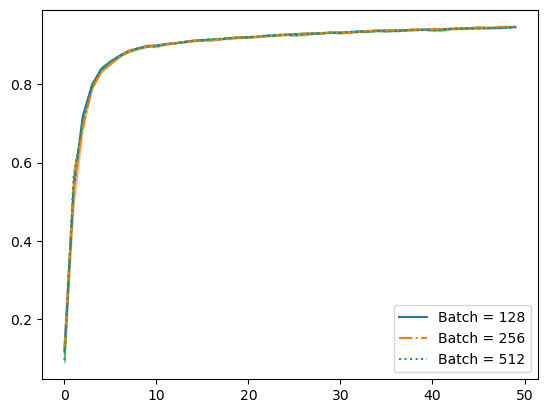

In [15]:
D = {}
Bs = [128,256,512]
K = 5
trials = 2
tp = "test_acc"
linestyles = ["solid",'dashdot','dotted']#,'dashed'
for B, ls in zip(Bs,linestyles):
    with open(f'results/MnistNewExp_angle45,K5,batch{B}iter=2.pkl', 'rb') as f:
        D = pickle.load(f)
    arr = np.zeros((trials,len(D[B][0][tp])))
    for i in range(trials):
        arr[i] = np.array(D[B][i][tp])
    yfit = arr.mean(0)
    dyfit = arr.std(0)
    print(B,yfit.max())
    p = plt.plot(yfit,linestyle=ls,label="Batch = "+str(B))
    color=p[0].get_color()
    plt.fill_between(np.arange(len(yfit)),yfit - dyfit, yfit + dyfit,color=color,alpha=0.4)
plt.legend()

## AUXMVR

In [16]:
def AUXMVR(K,lrs,a, model, loss_fn,epochs):

    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    for t in tqdm(range(epochs)):
         #print(f"Epoch {t+1}\n-------------------------------")
            prev_model = copy.deepcopy(model).to(device)
            size = len(train_dataloaderF.dataset)
            dloadH = iter(train_dataloaderH)
            for batch, (X, y) in enumerate(train_dataloaderF):
                lr = lrs[t*len(train_dataloaderF) + batch]

                gf,_ = compute_grad(model,X,y,device)
                gf_prev,_ = compute_grad(prev_model,X,y,device)
                
                with torch.no_grad():
                    if batch == 0 and t == 0:
                        m = gf
                    else:
                        m = [gf_ + (1 - a) * (m_ - gf_p) for gf_,m_,gf_p in zip(gf,m,gf_prev)]
                        

                for k in range(K):
                    if k==0:
                        prev_model = copy.deepcopy(model).to(device)
                        
                    try:
                        (X, y) = next(dloadH)
                    except StopIteration:
                        dloadH = iter(train_dataloaderH)
                        (X, y) = next(dloadH)

                    gh,_ = compute_grad(model,X,y,device)
                    gh_snap,_ = compute_grad(prev_model,X,y,device)
                    

                    with torch.no_grad():
                        for i,param in enumerate(model.parameters()):
                            param -= lr * (gh[i] - gh_snap[i] + m[i])

                if batch % 50 == 0:
                    with torch.no_grad():
                        loss = 0
                        for X, y in train_dataloaderF:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            loss += loss_fn(pred, y).item()

                    loss /= len(train_dataloaderF)
                    Res["train_loss"].append(loss)
                    #test
                    size = len(test_dataloader.dataset)
                    num_batches = len(test_dataloader)
                    test_loss, correct = 0, 0

                    with torch.no_grad():
                        for X, y in test_dataloader:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            test_loss += loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                    test_loss /= num_batches
                    correct /= size
                    Res["test_loss"].append(test_loss)
                    Res["test_acc"].append(correct)
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [17]:
Ks = [1,5,10] 
Angles = [45]
trials = 4
epochs = 10
T = np.arange(len(train_dataloaderF)*epochs) + 1
lrs = 1e-1 * np.ones_like(T) #1e-1 / np.sqrt(T)
a = 0.1
for angle in Angles:
    print("Angle=", angle)
    Res = {K:{} for K in Ks}
    training_data_rotated = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(),ROTATE(angle)])
    )
    train_dataloaderH = DataLoader(training_data_rotated, batch_size=64,shuffle=True)
    for K in Ks:
        print("K=",K)
        for t in range(trials):
            print("---------t=",t)
            model = NeuralNetwork().to(device)
            Res[K][t] = AUXMVR(K,lrs,a, model, loss_fn,epochs)
            with open(f'results/MnistExpAUXMVR_angle{angle}_2.pkl', 'wb') as f:
                 pickle.dump(Res, f)

Angle= 45
K= 1
---------t= 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:39<00:00, 57.93s/it]


---------t= 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:47<00:00, 58.74s/it]


---------t= 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:51<00:00, 59.19s/it]


---------t= 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:51<00:00, 59.13s/it]


K= 5
---------t= 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:47<00:00, 82.71s/it]


---------t= 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:54<00:00, 83.41s/it]


---------t= 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:54<00:00, 65.50s/it]


---------t= 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:16<00:00, 67.67s/it]


K= 10
---------t= 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [16:02<00:00, 96.30s/it]


---------t= 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [16:02<00:00, 96.27s/it]


---------t= 2


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:01<00:00, 114.19s/it]


---------t= 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [15:53<00:00, 95.34s/it]


In [44]:
with open(f'results/MnistExp_angle45.pkl', 'rb') as f:
        D = pickle.load(f)

10 0.9447
10 0.9447


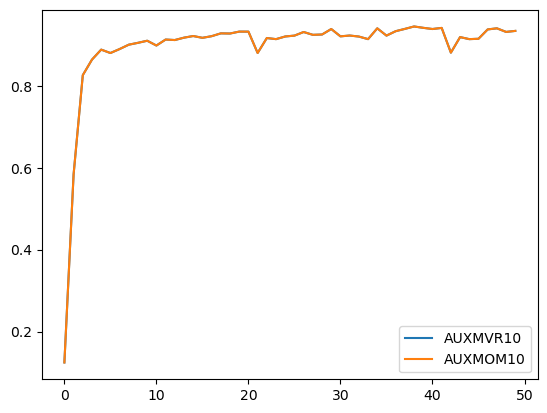

In [54]:
tp = "test_acc"
linestyles = ["solid",'dashdot','dotted']#,'dashed'
Dic = {"AUXMVR":Res,"AUXMOM":D}
K = 10
ls = linestyles[0]
arr = np.zeros((trials,len(Res[K][0][tp])))
for alg in Dic:
        Res = Dic[alg]
        yfit = np.array(Res[K][0][tp])
        print(K,yfit.max())
        p = plt.plot(yfit,linestyle=ls,label=alg+str(K))
    #color=p[0].get_color()
    #plt.fill_between(np.arange(len(yfit)),yfit - dyfit, yfit + dyfit,color=color,alpha=0.4)
    
    
plt.legend()

1 2.3027706848814136
5 2.302045523866694
10 2.2999007329027705


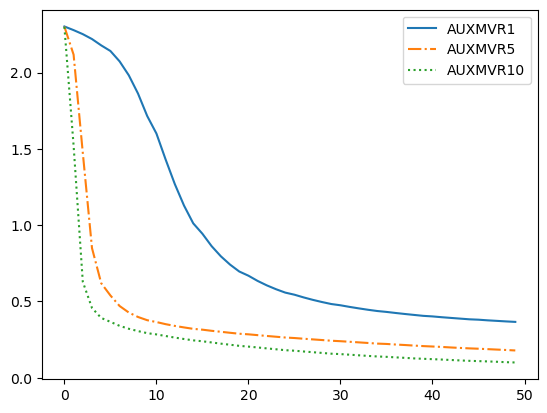

In [48]:
tp = "train_loss"
linestyles = ["solid",'dashdot','dotted']#,'dashed'
for K, ls in zip(Ks,linestyles):
    arr = np.zeros((trials,len(Res[K][0][tp])))
    for i in range(trials):
        arr[i] = np.array(Res[K][i][tp])
    yfit = arr.mean(0)
    dyfit = arr.std(0)
    print(K,yfit.max())
    p = plt.plot(yfit,linestyle=ls,label="AUXMVR"+str(K))
    #color=p[0].get_color()
    #plt.fill_between(np.arange(len(yfit)),yfit - dyfit, yfit + dyfit,color=color,alpha=0.4)
plt.legend()

### Naive algorithm implementation

In [ ]:
def NaiveAlg(K,lrs,a, model, loss_fn,epochs):

    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    for t in range(epochs):
         #print(f"Epoch {t+1}\n-------------------------------")
         size = len(train_dataloaderF.dataset)
         m_f = [None for _ in model.parameters()]
         dloadH = iter(train_dataloaderH)
         for batch, (X, y) in enumerate(train_dataloaderF):
             lr = lrs[t*len(train_dataloaderF) + batch]
             backup = copy.deepcopy(model).to(device)
             X, y = X.to(device), y.to(device)
             pred = model(X)
             loss = loss_fn(pred, y)
             model.zero_grad()
             loss.backward()
             with torch.no_grad():
                for i,p in enumerate(model.parameters()):
                    m_f[i] = p.grad if batch==0 else (1-a)*m_f[i] + a*p.grad

        
             try:
               (X, y) = next(dloadH)
             except StopIteration:
               dloadH = iter(train_dataloaderH)
               (X, y) = next(dloadH)
             X, y = X.to(device), y.to(device)
             for k in range(K):
                 # Compute prediction and loss
                 pred = backup(X)
                 loss = loss_fn(pred, y)

                 # Backpropagation
                 backup.zero_grad()
                 loss.backward()

                 grad_hx = [None for _ in backup.parameters()]
                 with torch.no_grad():
                     for i,param in enumerate(backup.parameters()):
                           grad_hx[i] = param.grad


                 pred = model(X)
                 loss = loss_fn(pred, y)

                 # Backpropagation
                 model.zero_grad()
                 loss.backward()

                 grad_hy = [None for _ in model.parameters()]
                 with torch.no_grad():
                     for i,param in enumerate(model.parameters()):
                         grad_hy[i] = param.grad

                 with torch.no_grad():
                     for i,param in enumerate(model.parameters()):
                       if k==0:
                          param -= lr * m_f[i]
                       else:
                          param -= lr * grad_hy[i]
             if batch % 50 == 0:
                 loss, current = loss.item(), batch * len(X)
                 # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                 Res["train_loss"].append(loss)
                 #test
                 size = len(test_dataloader.dataset)
                 num_batches = len(test_dataloader)
                 test_loss, correct = 0, 0

                 with torch.no_grad():
                    for X, y in test_dataloader:
                        X, y = X.to(device), y.to(device)
                        pred = model(X)
                        test_loss += loss_fn(pred, y).item()
                        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                 test_loss /= num_batches
                 correct /= size
                 Res["test_loss"].append(test_loss)
                 Res["test_acc"].append(correct)
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [ ]:
Ks = [1,5,10] 
Angles = [0,45,90,180]
trials = 10
epochs = 10
T = np.arange(len(train_dataloaderF)*epochs) + 1
lrs = 1e-2 * np.ones_like(T) #1e-1 / np.sqrt(T)
a = 0.1
for angle in Angles:
  print("Angle=", angle)
  Res = {K:{} for K in Ks}
  training_data_rotated = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(),ROTATE(angle)])
    )
  train_dataloaderH = DataLoader(training_data_rotated, batch_size=64,shuffle=True)
  for K in Ks:
    print("K=",K)
    for t in range(trials):
        print("---------t=",t)
        model = NeuralNetwork().to(device)
        Res[K][t] = NaiveAlg(K,lrs,a, model, loss_fn,epochs)
  with open(f'results/MnistExpNaiveangle{angle}.pkl', 'wb') as f:
        pickle.dump(Res, f)